In [3]:
#load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from nltk.util import ngrams
from functools import reduce
from scipy import stats
from ast import literal_eval
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [47]:
#load processed data
df = pd.read_csv('new2_tkdf.csv', converters = {
    'description': literal_eval, 'host_about': literal_eval, 
    'bigram_description': literal_eval, 'bigram_host_about': literal_eval})

In [48]:
#delete unnecessary col
df = df.drop('Unnamed: 0', axis = 1)

In [49]:
#take a look at the shape of the dataframe
df.shape

(5288, 45)

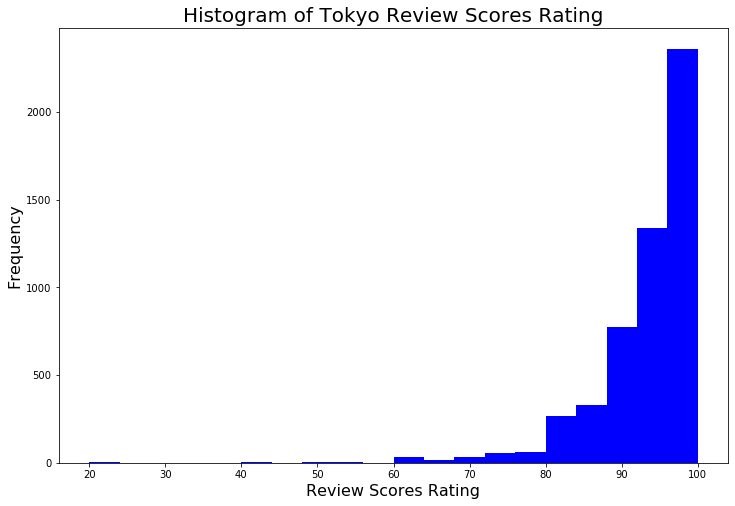

In [50]:
#plot local review score
plt.figure(figsize=(12,8))
plt.hist(df['review_scores_rating'], bins=20, color='b')
plt.title('Histogram of Tokyo Review Scores Rating', fontsize = 20)
plt.xlabel("Review Scores Rating", fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)


plt.savefig('tokyoreview.png')
plt.show()

In [51]:
print('The mean review scores rating is', df['review_scores_rating'].mean())
print("Percentage of Airbnb home rating less than 90 in Tokyo: {}%".format(round(sum(df.review_scores_rating < 85)/len(df),2)*100))
print("Percentage of Airbnb home rating being 100 in Tokyo:{}%".format(round(sum(df.review_scores_rating == 100)/len(df),2)*100))

The mean review scores rating is 92.99149016641452
Percentage of Airbnb home rating less than 90 in Tokyo: 10.0%
Percentage of Airbnb home rating being 100 in Tokyo:14.000000000000002%


In [52]:
df.amenities  #have a look at amenities

0       {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
1       {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
2       {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
3       {TV,Wifi,"Air conditioning",Kitchen,"Paid park...
4       {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
                              ...                        
5283    {Wifi,"Air conditioning",Elevator,Heating,Wash...
5284    {Wifi,"Air conditioning",Kitchen,"Smoking allo...
5285    {Wifi,"Air conditioning",Kitchen,Heating,Washe...
5286    {Wifi,"Air conditioning",Elevator,Heating,Wash...
5287    {TV,Wifi,"Air conditioning",Kitchen,Heating,Wa...
Name: amenities, Length: 5288, dtype: object

In [53]:
#handling amenities information
df.amenities = df.amenities.replace(to_replace = '["\d\s\-\/{\}]', value='', regex=True)
#a dummy dictionary for ameninties 
#containing all the amenities from all rows
amenities = {}
def itemfind(info):
    start = 0
    for idx, character in enumerate(info):
        if character == ",":
            if info[start:idx] not in amenities:  #each amenity as a key, an empty list as value
                amenities[info[start:idx]] = []
            start = idx+1
    if info[start:] not in amenities: #handling the last piece
            amenities[info[start:]] = []    
df.amenities.apply(lambda x: itemfind(x))

0       None
1       None
2       None
3       None
4       None
        ... 
5283    None
5284    None
5285    None
5286    None
5287    None
Name: amenities, Length: 5288, dtype: object

In [54]:
#binary label: if this amenity exist in this particular row, label as 1, else label as 0
count=0
def label(info):
    global amenities  #the dictionary 
    start = 0
    for idx, character in enumerate(info):
        if character == ",":
            if info[start:idx] in amenities:
                amenities[info[start:idx]].append(1)  #if it exists, label as 1
    global count
    count+=1
    for k,v in amenities.items():
        if len(v) < count: #if it is in the dict but not in the row, label as 0
            amenities[k].append(0)

df.amenities.apply(lambda x: label(x))

0       None
1       None
2       None
3       None
4       None
        ... 
5283    None
5284    None
5285    None
5286    None
5287    None
Name: amenities, Length: 5288, dtype: object

In [55]:
#new dataframe based on amenities dictionary
df2 = pd.DataFrame(amenities)
df = df.reset_index()
df = pd.concat([df, df2], axis=1, sort=False)
keys = list(amenities.keys())

In [56]:
keys  #take a look at what keys we have

['TV',
 'Internet',
 'Wifi',
 'Airconditioning',
 'Kitchen',
 'Paidparkingoffpremises',
 'Heating',
 'Washer',
 'Smokedetector',
 'Safetycard',
 'Essentials',
 'Shampoo',
 'Hangers',
 'Hairdryer',
 'Iron',
 'Laptopfriendlyworkspace',
 'translationmissing:en.hosting_amenity_',
 'Selfcheckin',
 'Lockbox',
 'Privateentrance',
 'Hotwater',
 'Bedlinens',
 'Extrapillowsandblankets',
 'Microwave',
 'Coffeemaker',
 'Refrigerator',
 'Dishesandsilverware',
 'Cookingbasics',
 'Oven',
 'Stove',
 'Patioorbalcony',
 'Longtermstaysallowed',
 'Familykidfriendly',
 'Carbonmonoxidedetector',
 'Firstaidkit',
 'Fireextinguisher',
 'hourcheckin',
 'Ethernetconnection',
 'Pocketwifi',
 'Petsliveonthisproperty',
 'Cat(s)',
 'Hottub',
 'Dryer',
 'Lockonbedroomdoor',
 'Dishwasher',
 'Other',
 'Buzzerwirelessintercom',
 'Bathtub',
 'Luggagedropoffallowed',
 'Hostgreetsyou',
 'Children’sbooksandtoys',
 'Children’sdinnerware',
 'Cleaningbeforecheckout',
 'CableTV',
 'Gardenorbackyard',
 'Singlelevelhome',
 'Babyb

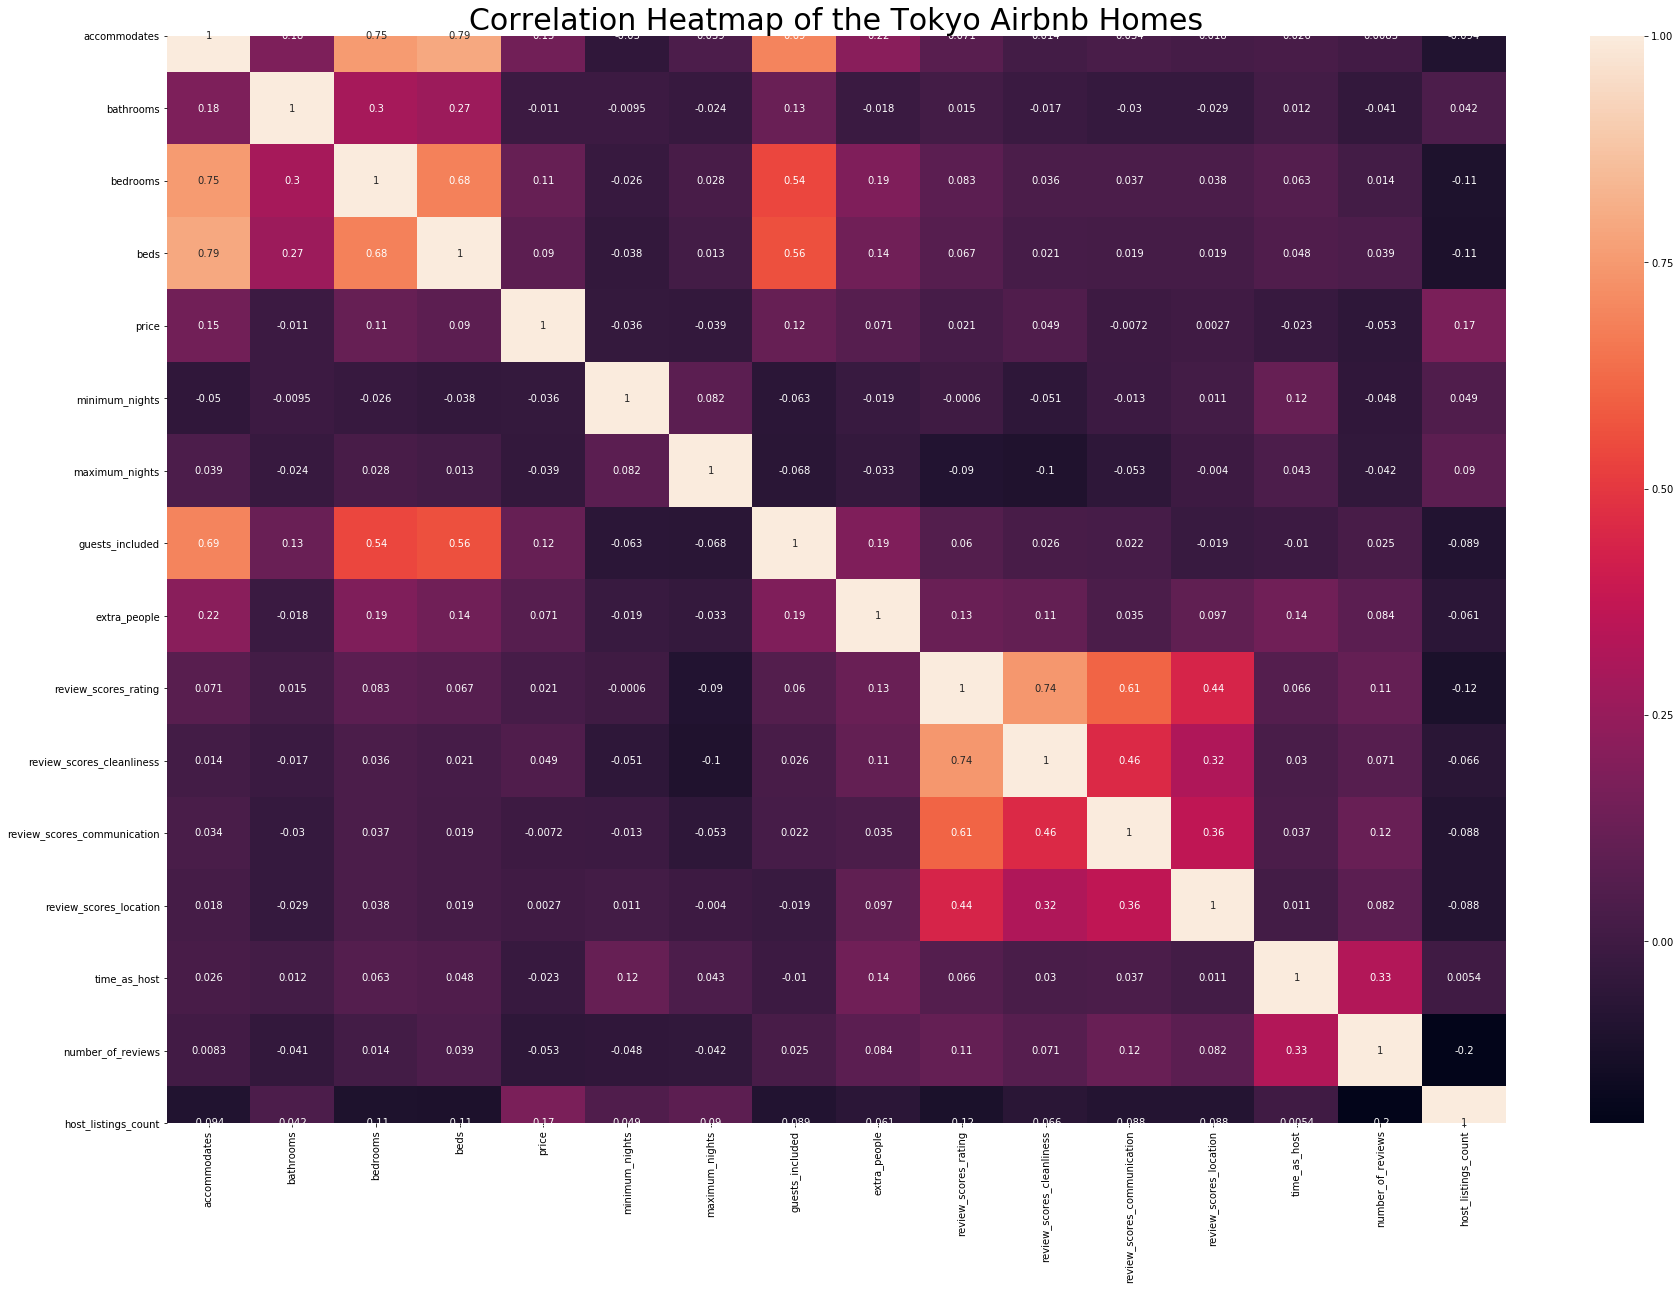

In [57]:
#heatmap
plt.rcParams['figure.figsize'] = (30, 20)
sns.heatmap(df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',              
              'maximum_nights', 'guests_included', 'extra_people','review_scores_rating', 
               'review_scores_cleanliness', 'review_scores_communication',
               'review_scores_location', 'time_as_host', 'number_of_reviews','host_listings_count']].corr(), annot = True)

plt.title('Correlation Heatmap of the Tokyo Airbnb Homes', fontsize = 30)

plt.savefig('heatmaptokyo.png')

In [58]:
#merge the two text info to one text
df['description'] = df['description'].apply(lambda x: ' '.join(x))
df['host_about'] = df['host_about'].apply(lambda x: ' '.join(x))
df['description_host'] = df['description'] + ' ' + df['host_about']

In [59]:
df['description_host']  #have a look at the combined one 

0       monthly private fully furnished house cozy rel...
1       license phone number hidden airbnb entire apar...
2       female traveller sorry boy couple long term st...
3       must read price adult adult small kid accept a...
4       stay help travel big hub station kitasenju wal...
                              ...                        
5283    apartment private bathroom toilet kitchenette ...
5284    hi welcome sway tokyo provide airbnb experienc...
5285    stay heart tokyo house near bustling shinjuku ...
5286    apartment private bathroom toilet kitchenette ...
5287    popular room convenient location central shopp...
Name: description_host, Length: 5288, dtype: object

In [60]:
#select features, target and split the dataset into train/test set
X = df[['description_host', 'accommodates', 'bathrooms', 'beds', 'bedrooms', 'price',
               'guests_included', 'extra_people','minimum_nights',              
              'maximum_nights', 'number_of_reviews', 'review_scores_location',
               'review_scores_cleanliness', 'review_scores_communication', 
               'time_as_host', 'host_response_rate','host_acceptance_rate', 'transit', 'host_has_profile_pic', 
               'host_identity_verified', 
                   'neighbourhood', 'property_type', 'room_type', 'bed_type', 
                   'security_deposit', 'cleaning_fee', 'instant_bookable',
                   'weekly_price', 'host_is_superhost', 'host_response_time'] + keys]
y = df[['review_scores_rating']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [61]:
#numeric attributes and pipeline building
numeric_data = ['accommodates', 'bathrooms', 'beds', 'bedrooms', 'price',
               'guests_included', 'extra_people','minimum_nights',              
              'maximum_nights', 'number_of_reviews', 'review_scores_location',
               'review_scores_cleanliness', 'review_scores_communication', 
               'time_as_host', 'host_response_rate','host_acceptance_rate' ]
numeric_pipe = Pipeline([('scale', StandardScaler())])

#categorical attributes and pipeline building 
categorical_data = ['transit', 'host_has_profile_pic', 'host_identity_verified', 
                   'neighbourhood', 'property_type', 'room_type', 'bed_type', 
                   'security_deposit', 'cleaning_fee', 'instant_bookable',
                   'weekly_price', 'host_is_superhost', 'host_response_time'] + keys
categorical_pipe = Pipeline([('onehot', OneHotEncoder(sparse=False, handle_unknown = 'ignore')), 
                     ('varthres', VarianceThreshold(threshold = 0.97*(1-0.97)))])

In [62]:
#text attributes and pipeline building 
text_data = 'description_host'
text_pipe1 = Pipeline([('Count', CountVectorizer(max_features = 10000, min_df = 0.0015, ngram_range = (1,2)))])
text_pipe2 = Pipeline([('Tfid', TfidfVectorizer(max_features = 10000, min_df = 0.0015, ngram_range = (1,2)))])

In [63]:
#build two preprocessors
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_data),
        ('cat', categorical_pipe, categorical_data),
        ('text1', text_pipe1, text_data)])
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_data),
        ('cat', categorical_pipe, categorical_data),
        ('text2', text_pipe2, text_data)])

### 1. Ridge with bag of words

In [64]:
#create the first pipeline(with bag of words) 
pipe1 = Pipeline(steps=[('preprocessor', preprocessor1),
                      ('regressor', Ridge())])

param_grid = {'regressor__alpha': np.logspace(-1,3, num = 50)}

clf1 = RandomizedSearchCV(pipe1, param_grid, cv = 5, verbose = 15, n_iter = 10, 
                           scoring = 'r2', n_jobs = 4, random_state = 123)

clf1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   27.5s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   31.6s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   32.1s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   33.0s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [65]:
#the parameters
print('optimzed paramters;', clf1.best_params_)

optimzed paramters; {'regressor__alpha': 568.9866029018293}


In [66]:
y_pred = clf1.predict(X_test)

#report the performance metric
train_r2 = round(clf1.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error', mae)

Training set r2: 0.74
Testing set r2: 0.71
Mean square error 14.05
Mean absolute error 2.63


In [67]:
#get feature importance
r1importance=[]
temp = clf1.best_estimator_['regressor'].coef_
for i in temp:
    for j in i:
        r1importance.append(j)

p1ohe_label = clf1.best_estimator_['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names()

p1boolean_feature_used = clf1.best_estimator_['preprocessor'].named_transformers_['cat']['varthres'].get_support()

p1cat_used = []

for idx, boolean in enumerate(p1boolean_feature_used):
    if boolean:
        p1cat_used.append(p1ohe_label[idx])


p1voc_used = list(clf1.best_estimator_['preprocessor'].named_transformers_['text1']['Count'].vocabulary_.keys()) 

p1labels = numeric_data+p1cat_used + p1voc_used        

In [68]:
p1ohe_label    #take a look at the encoded categorical features for pipeline1, to understand what the symbols stand for 

array(['x0_False', 'x0_True', 'x1_f', 'x1_t', 'x2_f', 'x2_t',
       'x3_Adachi District', 'x3_Akasaka', 'x3_Akihabara', 'x3_Aoyama',
       'x3_Arakawa District', 'x3_Asakusa/Ueno', 'x3_Bunkyo District',
       'x3_Chiyoda District', 'x3_Chūō District', 'x3_Ebisu/Daikanyama',
       'x3_Edogawa District', 'x3_Ginza', 'x3_Harajuku', 'x3_Ikebukuro',
       'x3_Itabashi District', 'x3_Katsushika District',
       'x3_Kita District', 'x3_Meguro District', 'x3_Minato District',
       'x3_Nakano District', 'x3_Nerima District', 'x3_Roppongi',
       'x3_Setagaya District', 'x3_Shibuya', 'x3_Shibuya District',
       'x3_Shimokitazawa', 'x3_Shinjuku', 'x3_Shinjuku District',
       'x3_Suginami District', 'x3_Sumida District', 'x3_Taito District',
       'x3_Toshima District', 'x3_Tsukiji', 'x3_Tsukishima',
       'x4_Aparthotel', 'x4_Apartment', 'x4_Bed and breakfast',
       'x4_Boutique hotel', 'x4_Bungalow', 'x4_Condominium',
       'x4_Guest suite', 'x4_Guesthouse', 'x4_Hostel', 'x4_Ho

In [69]:
print('Number of feature importance in the first pipeline: {}'.format(len(r1importance)))
print('Number of labels in the first pipeline: {}'.format(len(p1labels)))

Number of feature importance in the first pipeline: 10049
Number of labels in the first pipeline: 10049


In [70]:
#sort the labels by importance
r1sorted_importance = sorted(list(zip(p1labels, r1importance)), key = lambda x: abs(x[1]), reverse = True)

#sorted labels and sorted feature importance
r1sort_label = []
r1sort_importance = []
for label, value in r1sorted_importance:
    r1sort_label.append(label)
    r1sort_importance.append(value)

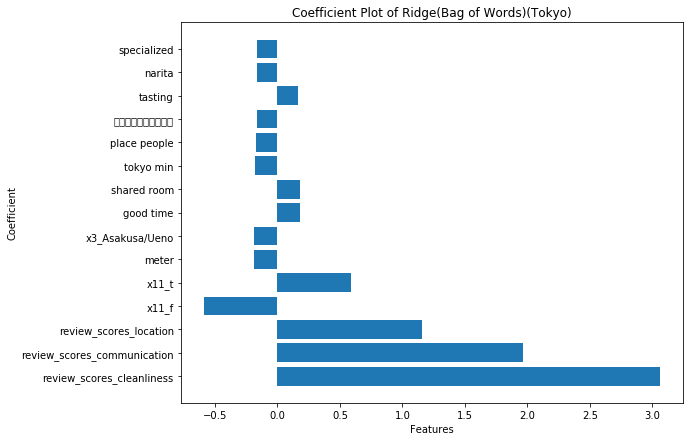

In [131]:
#plot
plt.figure(figsize = (9,7))
plt.barh(r1sort_label[:15], r1sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')  
plt.title('Coefficient Plot of Ridge(Bag of Words)(Tokyo)')
plt.savefig('tokyor1.png')

In [72]:
data={'feature':r1sort_label[:15],'ridge(bad of words)':r1sort_importance[:15]}
r1df=pd.DataFrame(data) 
r1df

,feature,ridge(bad of words)
0,review_scores_cleanliness,3.061630
1,review_scores_communication,1.961779
2,review_scores_location,1.157020
3,x11_f,-0.589857
4,x11_t,0.589857
5,meter,-0.188597
6,x3_Asakusa/Ueno,-0.184333
7,good time,0.183026
8,shared room,0.182400
9,tokyo min,-0.176283


### 2. Ridge with tfidf

In [73]:
#create the second pipeline(with tfidf) 
pipe2 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('regressor', Ridge())])

clf2 = RandomizedSearchCV(pipe2, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   20.0s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [74]:
print('Optimzed parameters:', clf2.best_params_)

Optimzed parameters: {'regressor__alpha': 23.29951810515372}


In [75]:
y_pred = clf2.predict(X_test)

In [76]:
train_r2 = round(clf2.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.7
Testing set r2: 0.71
Mean square error: 14.24
Mean absolute error: 2.68


In [77]:
r2importance=[]
coeff = clf2.best_estimator_['regressor'].coef_
for i in coeff:
    for j in i:
        r2importance.append(j)

        
p2ohe_label = clf2.best_estimator_['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names()


p2boolean_feature_used = clf2.best_estimator_['preprocessor'].named_transformers_['cat']['varthres'].get_support()

p2cat_used = []

for idx, boolean in enumerate(p2boolean_feature_used):
    if boolean:
        p2cat_used.append(p2ohe_label[idx])

p2voc_used = list(clf2.best_estimator_['preprocessor'].named_transformers_['text2']['Tfid'].vocabulary_.keys()) 

p2labels = numeric_data+p2cat_used + p2voc_used       

In [122]:
p2ohe_label    #take a look at the encoded categorical features for pipeline2, to understand what the symbols stand fo

array(['x0_False', 'x0_True', 'x1_f', 'x1_t', 'x2_f', 'x2_t',
       'x3_Adachi District', 'x3_Akasaka', 'x3_Akihabara', 'x3_Aoyama',
       'x3_Arakawa District', 'x3_Asakusa/Ueno', 'x3_Bunkyo District',
       'x3_Chiyoda District', 'x3_Chūō District', 'x3_Ebisu/Daikanyama',
       'x3_Edogawa District', 'x3_Ginza', 'x3_Harajuku', 'x3_Ikebukuro',
       'x3_Itabashi District', 'x3_Katsushika District',
       'x3_Kita District', 'x3_Meguro District', 'x3_Minato District',
       'x3_Nakano District', 'x3_Nerima District', 'x3_Roppongi',
       'x3_Setagaya District', 'x3_Shibuya', 'x3_Shibuya District',
       'x3_Shimokitazawa', 'x3_Shinjuku', 'x3_Shinjuku District',
       'x3_Suginami District', 'x3_Sumida District', 'x3_Taito District',
       'x3_Toshima District', 'x3_Tsukiji', 'x3_Tsukishima',
       'x4_Aparthotel', 'x4_Apartment', 'x4_Bed and breakfast',
       'x4_Boutique hotel', 'x4_Bungalow', 'x4_Condominium',
       'x4_Guest suite', 'x4_Guesthouse', 'x4_Hostel', 'x4_Ho

In [79]:
print('Number of feature importance in the second pipeline: {}'.format(len(r2importance)))
print('Number of labels in the second pipeline: {}'.format(len(p2labels)))

Number of feature importance in the second pipeline: 10049
Number of labels in the second pipeline: 10049


In [80]:
r2sorted_importance = sorted(list(zip(p2labels, r2importance)), key = lambda x: abs(x[1]), reverse = True)


r2sort_label = []
r2sort_importance = []
for label, value in r2sorted_importance:
    r2sort_label.append(label)
    r2sort_importance.append(value)

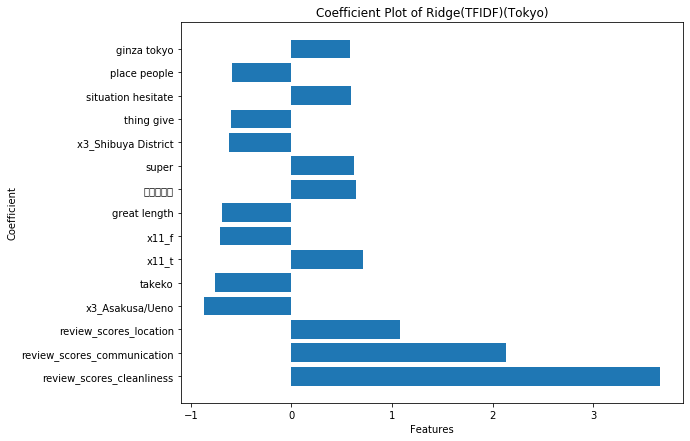

In [130]:
plt.figure(figsize = (9,7))
plt.barh(r2sort_label[:15], r2sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')  
plt.title('Coefficient Plot of Ridge(TFIDF)(Tokyo)')
plt.savefig('tokyor2.png')

In [82]:
data={'feature':r2sort_label[:15],'ridge(TFIDF)':r2sort_importance[:15]}
r2df=pd.DataFrame(data) 
r2df

,feature,ridge(TFIDF)
0,review_scores_cleanliness,3.665994
1,review_scores_communication,2.133918
2,review_scores_location,1.077961
3,x3_Asakusa/Ueno,-0.872699
4,takeko,-0.756255
5,x11_t,0.715077
6,x11_f,-0.715077
7,great length,-0.691162
8,여행하게된,0.638326
9,super,0.625475


### 3. Lasso with bag of words

In [83]:
pipe3 = Pipeline(steps=[('preprocessor', preprocessor1),
                      ('regressor', Lasso())])


param_grid = {'regressor__alpha': np.logspace(-1,3, num = 50)}

clf3 = RandomizedSearchCV(pipe3, param_grid, cv = 5, verbose = 15, n_iter = 10, 
                           scoring = 'r2', n_jobs = 4, random_state = 123)

clf3.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   19.2s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [84]:
print('optimzed parameters:', clf3.best_params_)

optimzed parameters: {'regressor__alpha': 0.1}


In [85]:
y_pred = clf3.predict(X_test)

In [86]:
train_r2 = round(clf3.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.67
Testing set r2: 0.7
Mean square error: 14.72
Mean absolute error: 2.72


In [87]:
l1importance= clf3.best_estimator_['regressor'].coef_


l1sorted_Importance = sorted(list(zip(p1labels, l1importance)), key = lambda x: abs(x[1]), reverse = True)


l1sort_label = []
l1sort_importance = []
for label, value in l1sorted_Importance:
    l1sort_label.append(label)
    l1sort_importance.append(value)

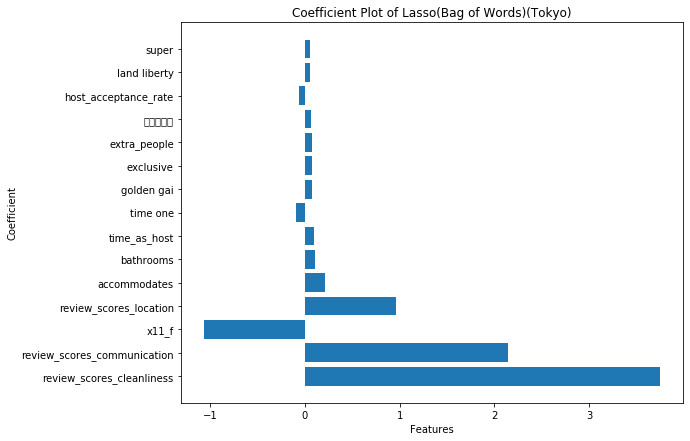

In [129]:
plt.figure(figsize = (9,7))
plt.barh(l1sort_label[:15], l1sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficient Plot of Lasso(Bag of Words)(Tokyo)')
plt.savefig('tokyol1.png')

In [89]:
data={'feature':l1sort_label[:15],'lasso(bag of words)':l1sort_importance[:15]}
l1df=pd.DataFrame(data) 
l1df

,feature,lasso(bag of words)
0,review_scores_cleanliness,3.746943
1,review_scores_communication,2.146220
2,x11_f,-1.065800
3,review_scores_location,0.966697
4,accommodates,0.208355
5,bathrooms,0.105436
6,time_as_host,0.100183
7,time one,-0.096751
8,golden gai,0.079355
9,exclusive,0.077824


### 4. Lasso with tfidf

In [90]:
pipe4 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('regressor', Lasso())])

clf4 = RandomizedSearchCV(pipe4, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   16.3s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [91]:
print('optimzed parameters:', clf4.best_params_)

optimzed parameters: {'regressor__alpha': 0.1}


In [92]:
y_pred = clf4.predict(X_test)

In [93]:
train_r2 = round(clf4.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.67
Testing set r2: 0.7
Mean square error: 14.85
Mean absolute error: 2.73


In [94]:
l2importance= clf4.best_estimator_['regressor'].coef_


l2sorted_Importance = sorted(list(zip(p2labels, l2importance)), key = lambda x: abs(x[1]), reverse = True)

l2sort_label = []
l2sort_importance = []
for label, value in l2sorted_Importance:
    l2sort_label.append(label)
    l2sort_importance.append(value)

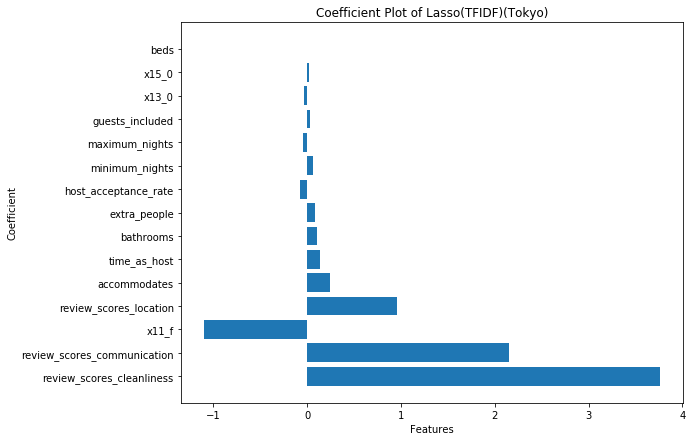

In [128]:
plt.figure(figsize = (9,7))
plt.barh(l2sort_label[:15], l2sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficient Plot of Lasso(TFIDF)(Tokyo)')
plt.savefig('tokyol2.png')

In [96]:
data={'feature':l2sort_label[:15],'lasso(TFIDF)':l2sort_importance[:15]}
l2df=pd.DataFrame(data) 
l2df

,feature,lasso(TFIDF)
0,review_scores_cleanliness,3.762771
1,review_scores_communication,2.153907
2,x11_f,-1.102462
3,review_scores_location,0.961990
4,accommodates,0.239803
5,time_as_host,0.133888
6,bathrooms,0.109817
7,extra_people,0.089086
8,host_acceptance_rate,-0.080032
9,minimum_nights,0.057841


### 5. Random Forest

In [98]:
pipe5 = Pipeline([('preprocessor', preprocessor1),
                  ('regressor', RandomForestRegressor())])

param_grid = {'regressor__n_estimators': np.arange(8,17,2), 
              'regressor__min_samples_split': np.arange(2,6),
             'regressor__min_samples_leaf': np.arange(1,5)}

clf5 = RandomizedSearchCV(pipe5, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf5.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   42.2s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   42.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   42.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   42.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  3.0min
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [99]:
print('optimized parameters:', clf5.best_params_)

optimized parameters: {'regressor__n_estimators': 16, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 3}


In [100]:
y_pred = clf5.predict(X_test)

In [101]:
train_r2 = round(clf5.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.87
Testing set r2: 0.66
Mean square error: 16.4
Mean absolute error: 2.56


In [103]:
rfimportance = clf5.best_estimator_['regressor'].feature_importances_

rfsorted_importance = sorted(list(zip(p1labels, rfimportance)), key = lambda x: abs(x[1]), reverse = True)

rfsort_label = []
rfsort_importance = []
for label, value in rfsorted_importance:
    rfsort_label.append(label)
    rfsort_importance.append(value)

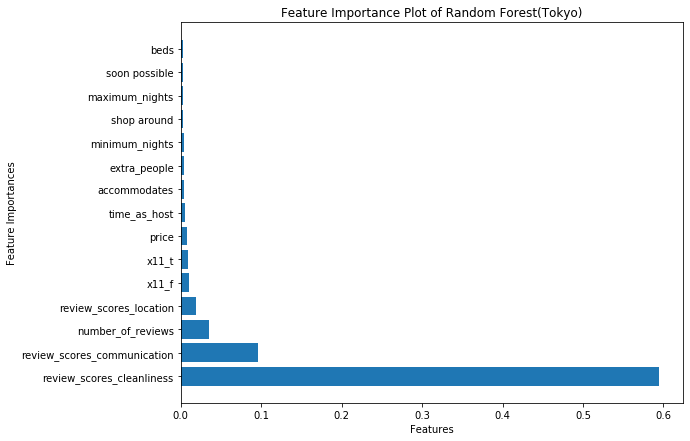

In [124]:
plt.figure(figsize = (9,7))
plt.barh(rfsort_label[:15], rfsort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature Importance Plot of Random Forest(Tokyo)')
plt.savefig('tokyorf.png')   

In [105]:
data={'feature':rfsort_label[:15],'random forest':rfsort_importance[:15]}
rfdf=pd.DataFrame(data) 
rfdf

,feature,random forest
0,review_scores_cleanliness,0.594552
1,review_scores_communication,0.095636
2,number_of_reviews,0.035284
3,review_scores_location,0.018731
4,x11_f,0.009893
5,x11_t,0.008377
6,price,0.008282
7,time_as_host,0.005673
8,accommodates,0.004267
9,extra_people,0.003839


### 6. Gradient boosting

In [106]:
pipe6 = Pipeline([('preprocessor', preprocessor1), 
                  ('regressor', GradientBoostingRegressor())])

param_grid = {'regressor__n_estimators': [100, 200, 300, 400, 500],
              'regressor__learning_rate': [0.001, 0.01, 0.1, 0.3],
              'regressor__max_depth': np.arange(3,6),
              'regressor__alpha': np.arange(0,1,0.1)}


clf6 = RandomizedSearchCV(pipe6, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf6.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  3.5min
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [116]:
print('optimized parameters:', clf6.best_params_)

optimized parameters: {'regressor__n_estimators': 200, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.1, 'regressor__alpha': 0.4}


In [117]:
y_pred = clf6.predict(X_test)

In [118]:
train_r2 = round(clf6.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.86
Testing set r2: 0.69
Mean square error: 14.95
Mean absolute error: 2.61


In [126]:
gbimportance = clf6.best_estimator_['regressor'].feature_importances_

gbsorted_importance = sorted(list(zip(p1labels, gbimportance)), key = lambda x: abs(x[1]), reverse = True)

gbsort_label = []
gbsort_importance = []
for label, value in gbsorted_importance:
    gbsort_label.append(label)
    gbsort_importance.append(value)

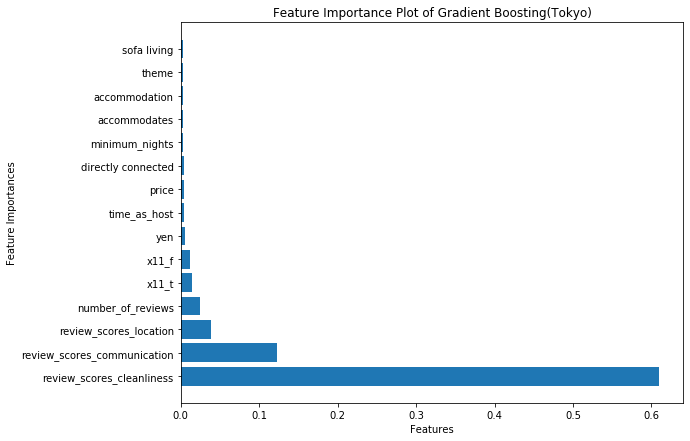

In [127]:
plt.figure(figsize = (9,7))
plt.barh(gbsort_label[:15], gbsort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature Importance Plot of Gradient Boosting(Tokyo)')
plt.savefig('tokyogb.png')

In [121]:
data={'feature':gbsort_label[:15],'gradient boosting':gbsort_importance[:15]}
gbdf=pd.DataFrame(data) 
gbdf

,feature,gradient boosting
0,review_scores_cleanliness,0.609788
1,review_scores_communication,0.122613
2,review_scores_location,0.038822
3,number_of_reviews,0.024917
4,x11_t,0.013624
5,x11_f,0.012151
6,yen,0.005134
7,time_as_host,0.004088
8,price,0.003710
9,directly connected,0.003631


### 7. Important features analysis

In [113]:
data_frames = [r1df,r2df,l1df,l2df,rfdf,gbdf]

In [114]:
#the features ranking top15 in all the models. 
df_merged1 = reduce(lambda left,right: pd.merge(left,right,on='feature',
                                            how='inner'), data_frames)
df_merged1

,feature,ridge(bad of words),ridge(TFIDF),lasso(bag of words),lasso(TFIDF),random forest,gradient boosting
0,review_scores_cleanliness,3.061630,3.665994,3.746943,3.762771,0.594552,0.609788
1,review_scores_communication,1.961779,2.133918,2.146220,2.153907,0.095636,0.122613
2,review_scores_location,1.157020,1.077961,0.966697,0.961990,0.018731,0.038822
3,x11_f,-0.589857,-0.715077,-1.065800,-1.102462,0.009893,0.012151


In [115]:
#the features ranking top15 in each model. 
df_merged2 = reduce(lambda left,right: pd.merge(left,right,on='feature',
                                            how='outer'), data_frames)
df_merged2

,feature,ridge(bad of words),ridge(TFIDF),lasso(bag of words),lasso(TFIDF),random forest,gradient boosting
0,review_scores_cleanliness,3.061630,3.665994,3.746943,3.762771,0.594552,0.609788
1,review_scores_communication,1.961779,2.133918,2.146220,2.153907,0.095636,0.122613
2,review_scores_location,1.157020,1.077961,0.966697,0.961990,0.018731,0.038822
3,x11_f,-0.589857,-0.715077,-1.065800,-1.102462,0.009893,0.012151
4,x11_t,0.589857,0.715077,NaN,NaN,0.008377,0.013624
5,meter,-0.188597,NaN,NaN,NaN,NaN,NaN
6,x3_Asakusa/Ueno,-0.184333,-0.872699,NaN,NaN,NaN,NaN
7,good time,0.183026,NaN,NaN,NaN,NaN,NaN
8,shared room,0.182400,NaN,NaN,NaN,NaN,NaN
9,tokyo min,-0.176283,NaN,NaN,NaN,NaN,NaN
